In [2]:
import scipy.io as io
import numpy as np

y=io.loadmat("D:\\机器学习前沿实验\\实验课一\\dataset\\FTD_90_200_fMRI.mat")

In [3]:
y

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Sep 15 16:13:18 2021',
 '__version__': '1.0',
 '__globals__': [],
 'FTD': array([[[ 2.50049135,  2.48836375,  0.76244127, ...,  1.58452119,
           2.1307843 ,  2.38140009],
         [ 2.45768574,  2.41266857, -0.78422818, ...,  2.03407663,
           2.03950974,  2.64254884],
         [-1.64347569, -0.44281807, -1.44156423, ...,  1.48753878,
           2.09132309,  2.80178515],
         ...,
         [ 0.70175193, -0.33569285, -0.08657972, ...,  1.94723672,
           1.99002767,  2.97593009],
         [-0.8417131 , -0.32816934,  0.30816443, ...,  1.11815507,
           1.74715135,  2.90560077],
         [-0.60596173, -0.65205069, -0.38014939, ...,  2.07912456,
           2.80800418,  3.82354762]],
 
        [[-3.21530128,  0.74852721, -0.94472378, ...,  3.17270744,
           3.55779983,  0.58324881],
         [-8.56478122, -2.44259909, -0.91971577, ...,  0.88943393,
           2.2078903 , -1.95835273],
     

# 为数组打上标签，FTD=0  NC=1

In [4]:
FTD=np.asarray(y['FTD'])
FTD_lable=np.full((FTD.shape[0],1),0,dtype=int)

In [5]:
FTD.shape

(95, 90, 200)

# 记录数组维度方便后续转化

In [6]:
m=FTD.shape[1]
n=FTD.shape[2]

In [7]:
NC=np.asarray(y['NC'])
NC_lable=np.full((NC.shape[0],1),1,dtype=int)

In [8]:
NC.shape

(86, 90, 200)

# 将数据转换为2维，方便后续数据划分

In [9]:
x = FTD.reshape(FTD.shape[0],-1)
y = NC.reshape(NC.shape[0],-1)

# 将数据合并

In [10]:
Label=np.vstack((FTD_lable,NC_lable))
Data=np.vstack((x,y))

# 将数据转换为原本的维度

In [11]:
Data=(Data.reshape(-1,m, n))
Data=Data.transpose((0,2,1))
from tensorflow.keras.utils import to_categorical
Label=to_categorical(Label)

In [12]:
print(Data.shape)
print(Label.shape)

(181, 200, 90)
(181, 2)


In [13]:
import time
import warnings
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import newaxis
import pandas as pd
from keras.models import Sequential
from keras.layers import Bidirectional,LSTM
from keras.layers.core import Dense, Activation, Dropout
import keras.layers as layers

In [14]:
import keras.backend as K
from keras.callbacks import LearningRateScheduler
 
def scheduler(epoch):
    # 每隔25个epoch，学习率减小为原来的1/10-lstm
    #if epoch % 5 == 0 and epoch != 0:
    if epoch % 25 == 0 and epoch != 0:
#         lr = K.get_value(model.optimizer.lr*0.01)#LSTM
        lr = K.get_value(model.optimizer.lr) #一维卷积
        K.set_value(model.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return K.get_value(model.optimizer.lr)
 
reduce_lr = LearningRateScheduler(scheduler)

# LSTM

In [15]:
def built_model():
    model = Sequential() #layers [128,64,32,16,4]
    model.add(LSTM(input_shape=(None,90),units=200,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(input_shape=(None,50),units=128,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(input_shape=(None,50),units=64,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=2))
    #model.add(Activation("linear"))
    model.add(Activation("softmax"))
    start = time.time()
    model.compile(optimizer = 'rmsprop',                 # 加速神经网络
        loss = 'categorical_crossentropy',   # 损失函数
        metrics = ['accuracy'], )
    return model

# 一维卷积

In [16]:
# def built_model(input=128):
#     model = Sequential()
#     model.add(layers.Convolution1D(128,3,strides=1))
#     model.add(layers.LayerNormalization())
#     model.add(Activation('relu'))
#     model.add(layers.Convolution1D(256,3,strides=1))
#     model.add(layers.LayerNormalization())
#     model.add(Activation('relu'))
#     model.add(layers.Convolution1D(128,3,strides=1))
#     model.add(layers.LayerNormalization())
#     model.add(Activation('relu'))
#     model.add(layers.GlobalAveragePooling1D())
#     model.add(Dense(2, activation='softmax'))
#     model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])
#     return model

In [17]:
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn import metrics

kf = KFold(n_splits=5, shuffle=True,random_state=42) # 5折交叉验证

i = 1
a=[]
h=np.asarray(Data)
Label=np.asarray(Label)
for train_index, test_index in kf.split(h, Label):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    X_train, X_test = h[train_index], h[test_index] 
    y_train, y_test = Label[train_index], Label[test_index]
    model=built_model()
    history=model.fit(X_train,y_train,batch_size=10,epochs=100,validation_data=(X_test,y_test),callbacks=[reduce_lr])
    x=np.asarray(history.history['accuracy']), 
    y=np.asarray(history.history['val_accuracy'])
    b=np.asarray(y)
    a.append(b.max())
    i += 1


1 of kfold 5
Epoch 1/100
15/15 [==============================] - 13s 415ms/step - loss: 0.7128 - accuracy: 0.5278 - val_loss: 0.7194 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 5s 320ms/step - loss: 0.6148 - accuracy: 0.6528 - val_loss: 0.7293 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 5s 357ms/step - loss: 0.4527 - accuracy: 0.8056 - val_loss: 0.9482 - val_accuracy: 0.6216 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 5s 327ms/step - loss: 0.2933 - accuracy: 0.9097 - val_loss: 0.7868 - val_accuracy: 0.5676 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 5s 334ms/step - loss: 0.1643 - accuracy: 0.9444 - val_loss: 0.9417 - val_accuracy: 0.6486 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 6s 368ms/step - loss: 0.0517 - accuracy: 0.9931 - val_loss: 1.2423 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 7/100
15/15 [==============================

15/15 [==============================] - 6s 428ms/step - loss: 7.8645e-08 - accuracy: 1.0000 - val_loss: 4.2555 - val_accuracy: 0.6757 - lr: 1.0000e-05
Epoch 52/100
15/15 [==============================] - 6s 421ms/step - loss: 2.5166e-07 - accuracy: 1.0000 - val_loss: 4.2570 - val_accuracy: 0.6757 - lr: 1.0000e-05
Epoch 53/100
15/15 [==============================] - 6s 425ms/step - loss: 1.2997e-07 - accuracy: 1.0000 - val_loss: 4.2607 - val_accuracy: 0.6757 - lr: 1.0000e-05
Epoch 54/100
15/15 [==============================] - 6s 415ms/step - loss: 8.9407e-08 - accuracy: 1.0000 - val_loss: 4.2621 - val_accuracy: 0.6757 - lr: 1.0000e-05
Epoch 55/100
15/15 [==============================] - 6s 395ms/step - loss: 8.0301e-08 - accuracy: 1.0000 - val_loss: 4.2639 - val_accuracy: 0.6757 - lr: 1.0000e-05
Epoch 56/100
15/15 [==============================] - 6s 429ms/step - loss: 1.8544e-07 - accuracy: 1.0000 - val_loss: 4.2662 - val_accuracy: 0.6757 - lr: 1.0000e-05
Epoch 57/100
15/15 [===

15/15 [==============================] - 7s 497ms/step - loss: 2.5249e-07 - accuracy: 1.0000 - val_loss: 4.2995 - val_accuracy: 0.6757 - lr: 1.0000e-06

2 of kfold 5
Epoch 1/100
15/15 [==============================] - 19s 607ms/step - loss: 0.7455 - accuracy: 0.4345 - val_loss: 0.6825 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 7s 457ms/step - loss: 0.6350 - accuracy: 0.6138 - val_loss: 0.6583 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 7s 434ms/step - loss: 0.4376 - accuracy: 0.8414 - val_loss: 0.8271 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 7s 457ms/step - loss: 0.2837 - accuracy: 0.8828 - val_loss: 0.8971 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 7s 462ms/step - loss: 0.0997 - accuracy: 0.9793 - val_loss: 1.1696 - val_accuracy: 0.6389 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 

15/15 [==============================] - 7s 480ms/step - loss: 1.5834e-06 - accuracy: 1.0000 - val_loss: 4.7612 - val_accuracy: 0.5833 - lr: 1.0000e-04
lr changed to 1.0000000474974514e-05
Epoch 51/100
15/15 [==============================] - 7s 495ms/step - loss: 9.7998e-07 - accuracy: 1.0000 - val_loss: 4.7664 - val_accuracy: 0.5833 - lr: 1.0000e-05
Epoch 52/100
15/15 [==============================] - 7s 495ms/step - loss: 9.3148e-07 - accuracy: 1.0000 - val_loss: 4.7673 - val_accuracy: 0.5833 - lr: 1.0000e-05
Epoch 53/100
15/15 [==============================] - 8s 561ms/step - loss: 1.3680e-06 - accuracy: 1.0000 - val_loss: 4.7788 - val_accuracy: 0.5833 - lr: 1.0000e-05
Epoch 54/100
15/15 [==============================] - 8s 553ms/step - loss: 1.6147e-06 - accuracy: 1.0000 - val_loss: 4.7794 - val_accuracy: 0.5833 - lr: 1.0000e-05
Epoch 55/100
15/15 [==============================] - 7s 491ms/step - loss: 1.3853e-06 - accuracy: 1.0000 - val_loss: 4.7871 - val_accuracy: 0.5833 - l

15/15 [==============================] - 9s 585ms/step - loss: 6.4209e-07 - accuracy: 1.0000 - val_loss: 4.8384 - val_accuracy: 0.5833 - lr: 1.0000e-06
Epoch 100/100
15/15 [==============================] - 9s 578ms/step - loss: 9.5367e-07 - accuracy: 1.0000 - val_loss: 4.8395 - val_accuracy: 0.5833 - lr: 1.0000e-06

3 of kfold 5
Epoch 1/100
15/15 [==============================] - 18s 786ms/step - loss: 0.7153 - accuracy: 0.5448 - val_loss: 0.6745 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 10s 646ms/step - loss: 0.6066 - accuracy: 0.7103 - val_loss: 0.7740 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 10s 660ms/step - loss: 0.4038 - accuracy: 0.8690 - val_loss: 1.0844 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 11s 772ms/step - loss: 0.1840 - accuracy: 0.9448 - val_loss: 1.3393 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 5/100
15/15 [=====================

15/15 [==============================] - 12s 810ms/step - loss: 2.9128e-06 - accuracy: 1.0000 - val_loss: 6.5672 - val_accuracy: 0.4722 - lr: 1.0000e-04
Epoch 50/100
15/15 [==============================] - 12s 830ms/step - loss: 2.8215e-06 - accuracy: 1.0000 - val_loss: 6.5858 - val_accuracy: 0.4722 - lr: 1.0000e-04
lr changed to 1.0000000474974514e-05
Epoch 51/100
15/15 [==============================] - 12s 820ms/step - loss: 3.4274e-06 - accuracy: 1.0000 - val_loss: 6.5845 - val_accuracy: 0.4722 - lr: 1.0000e-05
Epoch 52/100
15/15 [==============================] - 12s 799ms/step - loss: 3.0526e-06 - accuracy: 1.0000 - val_loss: 6.5802 - val_accuracy: 0.4722 - lr: 1.0000e-05
Epoch 53/100
15/15 [==============================] - 12s 800ms/step - loss: 1.8950e-06 - accuracy: 1.0000 - val_loss: 6.5845 - val_accuracy: 0.4722 - lr: 1.0000e-05
Epoch 54/100
15/15 [==============================] - 12s 814ms/step - loss: 2.9539e-06 - accuracy: 1.0000 - val_loss: 6.5962 - val_accuracy: 0.47

15/15 [==============================] - 6s 399ms/step - loss: 2.7944e-06 - accuracy: 1.0000 - val_loss: 6.7260 - val_accuracy: 0.4722 - lr: 1.0000e-06
Epoch 99/100
15/15 [==============================] - 6s 403ms/step - loss: 3.0616e-06 - accuracy: 1.0000 - val_loss: 6.7270 - val_accuracy: 0.4722 - lr: 1.0000e-06
Epoch 100/100
15/15 [==============================] - 6s 397ms/step - loss: 1.7659e-06 - accuracy: 1.0000 - val_loss: 6.7277 - val_accuracy: 0.4722 - lr: 1.0000e-06

4 of kfold 5
Epoch 1/100
15/15 [==============================] - 14s 485ms/step - loss: 0.7178 - accuracy: 0.4897 - val_loss: 0.6864 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 6s 387ms/step - loss: 0.6439 - accuracy: 0.6207 - val_loss: 0.6864 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 6s 396ms/step - loss: 0.4522 - accuracy: 0.8345 - val_loss: 0.7805 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
15/15 [===============

15/15 [==============================] - 6s 411ms/step - loss: 2.8446e-07 - accuracy: 1.0000 - val_loss: 5.6864 - val_accuracy: 0.5556 - lr: 1.0000e-04
Epoch 49/100
15/15 [==============================] - 6s 423ms/step - loss: 2.3842e-07 - accuracy: 1.0000 - val_loss: 5.7009 - val_accuracy: 0.5556 - lr: 1.0000e-04
Epoch 50/100
15/15 [==============================] - 6s 391ms/step - loss: 2.2444e-07 - accuracy: 1.0000 - val_loss: 5.7244 - val_accuracy: 0.5556 - lr: 1.0000e-04
lr changed to 1.0000000474974514e-05
Epoch 51/100
15/15 [==============================] - 6s 389ms/step - loss: 2.4746e-07 - accuracy: 1.0000 - val_loss: 5.7257 - val_accuracy: 0.5556 - lr: 1.0000e-05
Epoch 52/100
15/15 [==============================] - 6s 399ms/step - loss: 2.4335e-07 - accuracy: 1.0000 - val_loss: 5.7277 - val_accuracy: 0.5556 - lr: 1.0000e-05
Epoch 53/100
15/15 [==============================] - 6s 410ms/step - loss: 1.8827e-07 - accuracy: 1.0000 - val_loss: 5.7295 - val_accuracy: 0.5556 - l

15/15 [==============================] - 6s 418ms/step - loss: 1.9485e-07 - accuracy: 1.0000 - val_loss: 5.7637 - val_accuracy: 0.5556 - lr: 1.0000e-06
Epoch 98/100
15/15 [==============================] - 7s 487ms/step - loss: 3.0008e-07 - accuracy: 1.0000 - val_loss: 5.7633 - val_accuracy: 0.5556 - lr: 1.0000e-06
Epoch 99/100
15/15 [==============================] - 6s 419ms/step - loss: 2.4171e-07 - accuracy: 1.0000 - val_loss: 5.7635 - val_accuracy: 0.5556 - lr: 1.0000e-06
Epoch 100/100
15/15 [==============================] - 6s 408ms/step - loss: 2.6555e-07 - accuracy: 1.0000 - val_loss: 5.7637 - val_accuracy: 0.5556 - lr: 1.0000e-06

5 of kfold 5
Epoch 1/100
15/15 [==============================] - 17s 644ms/step - loss: 0.7174 - accuracy: 0.5241 - val_loss: 0.7266 - val_accuracy: 0.4722 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 8s 532ms/step - loss: 0.5856 - accuracy: 0.7034 - val_loss: 0.7746 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 3/100
15/15 [======

15/15 [==============================] - 8s 555ms/step - loss: 5.6270e-06 - accuracy: 1.0000 - val_loss: 5.2971 - val_accuracy: 0.6111 - lr: 1.0000e-04
Epoch 48/100
15/15 [==============================] - 8s 555ms/step - loss: 3.0221e-06 - accuracy: 1.0000 - val_loss: 5.3088 - val_accuracy: 0.6111 - lr: 1.0000e-04
Epoch 49/100
15/15 [==============================] - 8s 552ms/step - loss: 3.1405e-06 - accuracy: 1.0000 - val_loss: 5.3222 - val_accuracy: 0.6111 - lr: 1.0000e-04
Epoch 50/100
15/15 [==============================] - 8s 537ms/step - loss: 2.3167e-06 - accuracy: 1.0000 - val_loss: 5.3114 - val_accuracy: 0.6111 - lr: 1.0000e-04
lr changed to 1.0000000474974514e-05
Epoch 51/100
15/15 [==============================] - 7s 497ms/step - loss: 3.0830e-06 - accuracy: 1.0000 - val_loss: 5.3249 - val_accuracy: 0.6111 - lr: 1.0000e-05
Epoch 52/100
15/15 [==============================] - 9s 595ms/step - loss: 2.2609e-06 - accuracy: 1.0000 - val_loss: 5.3328 - val_accuracy: 0.6111 - l

15/15 [==============================] - 10s 643ms/step - loss: 1.3804e-06 - accuracy: 1.0000 - val_loss: 5.3877 - val_accuracy: 0.6111 - lr: 1.0000e-06
Epoch 97/100
15/15 [==============================] - 9s 608ms/step - loss: 1.4642e-06 - accuracy: 1.0000 - val_loss: 5.3876 - val_accuracy: 0.6111 - lr: 1.0000e-06
Epoch 98/100
15/15 [==============================] - 8s 512ms/step - loss: 1.8095e-06 - accuracy: 1.0000 - val_loss: 5.3876 - val_accuracy: 0.6111 - lr: 1.0000e-06
Epoch 99/100
15/15 [==============================] - 7s 502ms/step - loss: 2.7911e-06 - accuracy: 1.0000 - val_loss: 5.3863 - val_accuracy: 0.6111 - lr: 1.0000e-06
Epoch 100/100
15/15 [==============================] - 7s 480ms/step - loss: 1.1411e-06 - accuracy: 1.0000 - val_loss: 5.3857 - val_accuracy: 0.6111 - lr: 1.0000e-06


In [18]:
a=np.asarray(a)
print(a.mean())

0.6405405402183533


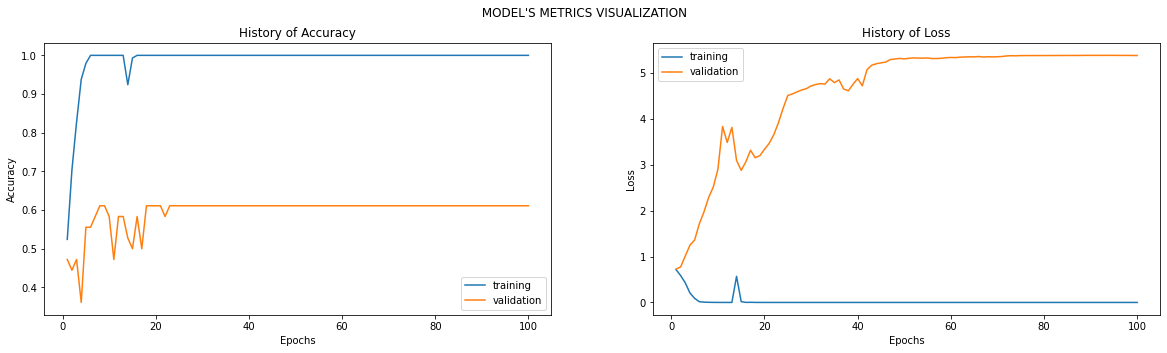

In [19]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    


    plt.show()
    
import matplotlib.pyplot as plt
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
              )

In [19]:
import tensorflow as tf
from tensorflow import keras

import tensorflow as tf

# 位置编码信息
def positional_embedding(maxlen, model_size):
    PE = np.zeros((maxlen, model_size))
    for i in range(maxlen):
        for j in range(model_size):
            if j % 2 == 0:
                PE[i, j] = np.sin(i / 10000 ** (j / model_size))
            else:
                PE[i, j] = np.cos(i / 10000 ** ((j-1) / model_size))
    PE = tf.constant(PE, dtype=tf.float32)
    return PE

class MultiHeadAttention(keras.Model):
    def __init__(self, model_size, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)

        self.model_size = model_size
        self.num_heads = num_heads
        self.head_size = model_size // num_heads
        self.WQ = keras.layers.Dense(model_size, name="dense_query")
        self.WK = keras.layers.Dense(model_size, name="dense_key")
        self.WV = keras.layers.Dense(model_size, name="dense_value")
        self.dense = keras.layers.Dense(model_size)

    def call(self, query, key, value, mask):
        # query: (batch, maxlen, model_size)
        # key  : (batch, maxlen, model_size)
        # value: (batch, maxlen, model_size)
        batch_size = tf.shape(query)[0]

        # shape: (batch, maxlen, model_size)
        query = self.WQ(query)
        key = self.WK(key)
        value = self.WV(value)

        def _split_heads(x):
            x = tf.reshape(x, shape=[batch_size, -1, self.num_heads, self.head_size])
            return tf.transpose(x, perm=[0, 2, 1, 3])

        # shape: (batch, num_heads, maxlen, head_size)
        query = _split_heads(query)
        key = _split_heads(key)
        value = _split_heads(value)

        # shape: (batch, num_heads, maxlen, maxlen)
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        # 缩放 matmul_qk
        dk = tf.cast(query.shape[-1], tf.float32)
        score = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            # mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype=tf.float32)
            score += (1 - mask) * -1e9

        alpha = tf.nn.softmax(score)
        context = tf.matmul(alpha, value)
        context = tf.transpose(context, perm=[0, 2, 1, 3])
        context = tf.reshape(context, (batch_size, -1, self.model_size))
        output = self.dense(context)
            
        return output

    # position-wise feed forward network
class FeedForwardNetwork(keras.Model):
    def __init__(self, dff_size, model_size):
        super(FeedForwardNetwork, self).__init__()
        self.dense1 = keras.layers.Dense(dff_size, activation="relu")
        self.dense2 = keras.layers.Dense(model_size)
    
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

    # Encoder Layer层
class EncoderLayer(keras.layers.Layer):
    def __init__(self, model_size, num_heads, dff_size, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.attention = MultiHeadAttention(model_size, num_heads)
        self.ffn = FeedForwardNetwork(dff_size, model_size)
        
        # Layer Normalization
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        # multi head attention
        attn_output = self.attention(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        # residual connection
        out1 = self.layernorm1(x + attn_output)
        # ffn layer
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Residual connection
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2
# 多层Encoder
class Encoder(keras.Model):
    def __init__(self, num_layers, model_size, num_heads, dff_size, vocab_size, maxlen, rate=0.1):
        super(Encoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        
        self.embedding = keras.layers.Embedding(vocab_size, model_size)
        self.pos_embedding = positional_embedding(maxlen, model_size)
        
        self.encoder_layers = [EncoderLayer(model_size,num_heads,dff_size,rate) for _ in range(num_layers)]
        self.dropout = keras.layers.Dropout(rate)
        
    def call(self, x, training, padding_mask):
        # input embedding + positional embedding
        x = self.embedding(x) + self.pos_embedding
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training, padding_mask)
        return x
# Decoder Layer
class DecoderLayer(keras.layers.Layer):
    def __init__(self, model_size, num_heads, dff_size, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mask_attention = MultiHeadAttention(model_size, num_heads)
        self.attention = MultiHeadAttention(model_size, num_heads)
        self.ffn = FeedForwardNetwork(dff_size, model_size)
        
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn_decoder = self.mask_attention(x, x, x, look_ahead_mask)
        attn_decoder = self.dropout1(attn_decoder, training=training)
        out1 = self.layernorm1(x + attn_decoder)
        
        attn_encoder_decoder = self.attention(out1, enc_output, enc_output, padding_mask)
        attn_encoder_decoder = self.dropout2(attn_encoder_decoder, training=training)
        out2 = self.layernorm2(out1 + attn_encoder_decoder)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)
        
        return out3
# 多层Decoder
class Decoder(keras.Model):
    def __init__(self, num_layers, model_size, num_heads, dff_size, vocab_size, maxlen, rate=0.1):
        super(Decoder, self).__init__()
        
        self.model_size = model_size
        self.num_layers = num_layers
        
        self.embedding = keras.layers.Embedding(vocab_size, model_size)
        self.pos_embedding = positional_embedding(maxlen, model_size)
        
        self.decoder_layers = [DecoderLayer(model_size,num_heads,dff_size,rate) for _ in range(num_layers)]
        self.dropout = keras.layers.Dropout(rate)
        
    def call(self, enc_output, x, training, look_ahead_mask, padding_mask):
        # input embedding + positional embedding
        x = self.embedding(x) + self.pos_embedding
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.decoder_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
        return x
# padding填充mask
def padding_mask(seq):
    mask = tf.cast(tf.math.not_equal(seq, 0), dtype=tf.float32)
    mask = mask[:, tf.newaxis, tf.newaxis, :]
    return mask
'''
-------------------
>> inputs = tf.constant([[1,2,3,0],[4,5,0,0]])
>> mask = padding_mask(inputs)
tf.Tensor(
[[[[1. 1. 1. 0.]]]
 [[[1. 1. 0. 0.]]]], shape=(2, 1, 1, 4), dtype=float32)
-------------------
'''

# decode mask
def look_ahead_mask(size):
    ahead_mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    ahead_mask = tf.cast(ahead_mask, dtype=tf.float32)
    return ahead_mask
'''
-------------------
>> inputs = tf.constant(4)
>> mask = look_ahead_mask(inputs)
<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]], dtype=float32)>
-------------------
'''

def create_mask(inp, tar):
    enc_padding_mask = padding_mask(inp)
    dec_padding_mask = padding_mask(tar)
    ahead_mask = look_ahead_mask(tf.shape(tar)[1])
    combined_mask = tf.minimum(dec_padding_mask, ahead_mask)
    return enc_padding_mask, dec_padding_mask, combined_mask

# Encoder和Decoder组合成Transformer
class Transformer(keras.Model):
    def __init__(self, num_layers, model_size, num_heads, dff_size, vocab_size, maxlen, training=True, rete=0.1):
        super(Transformer, self).__init__()
        self.training = training
        
        self.encoder = Encoder(num_layers, model_size, num_heads, dff_size, vocab_size, maxlen)
        self.decoder = Decoder(num_layers, model_size, num_heads, dff_size, vocab_size, maxlen)
        self.final_dense = keras.layers.Dense(vocab_size, name="final_output")
        
    def call(self, all_inputs):
        sources, targets = all_inputs

        enc_padding_mask, dec_padding_mask, combined_mask = create_mask(sources, targets)

        enc_output = self.encoder(sources, self.training, enc_padding_mask)
        dec_output = self.decoder(enc_output, targets, self.training, combined_mask , dec_padding_mask)
        
        final_output = self.final_dense(dec_output)
        
        return final_output

In [36]:
num_layers = 4
model_size = 768
num_heads = 12
dff_size = 1024
maxlen = 10
vocab_size = 10000

enc_inputs = keras.layers.Input(shape=(maxlen,), name="enc_input")
dec_inputs = keras.layers.Input(shape=(maxlen,), name="dec_input")
dec_outputs = keras.layers.Input(shape=(maxlen,), name="dec_output")

transformer = Transformer(num_layers=num_layers, 
                        model_size=model_size, 
                        num_heads=num_heads, 
                        dff_size=dff_size, 
                        vocab_size=vocab_size, 
                        maxlen=maxlen)
final_output = transformer([enc_inputs, dec_inputs])

model = keras.models.Model(inputs=[enc_inputs, dec_inputs], outputs=final_output)
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 dec_input (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 transformer_9 (Transformer)    (None, 10, 10000)    64026384    ['enc_input[0][0]',              
                                                                  'dec_input[0][0]']              
                                                                                                  
Total params: 64,026,384
Trainable params: 64,026,384
Non-trainable params: 0
______________

In [ ]:
Data.reshape

In [39]:
model((Data[0][0],Label[0:10][1]),Label[0:10][1])

InvalidArgumentError: Exception encountered when calling layer "transformer_9" (type Transformer).

Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: model_2/transformer_9/strided_slice/

Call arguments received:
  • all_inputs=['tf.Tensor(shape=(90,), dtype=float32)', 'tf.Tensor(shape=(2,), dtype=float32)']

In [27]:
model = Sequential() #layers [200,50,50,50,50,1]
model.add(LSTM(input_shape=(None,90),units=200,return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.LayerNormalization())
model.add(LSTM(input_shape=(None,50),units=200,return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.LayerNormalization())
model.add(LSTM(input_shape=(None,50),units=90,return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.LayerNormalization())
model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.2))
model.add(layers.LayerNormalization())
model.add(Dense(units=4))
#model.add(Activation("linear"))
model.add(Activation("sigmoid"))
start = time.time()
model.compile(loss="mse", optimizer="rmsprop",metrics='accuracy')
print("Compilation Time : ", time.time() - start)

Compilation Time :  0.00392460823059082


In [ ]:
model.fit(Train.transpose((0,2,1)),label_train,batch_size=5,epochs=50,validation_split=0.05)

In [29]:
loss,acu = model.evaluate(Test.transpose((0,2,1)),label_test)
print(acu)

2/2 [==============================] - 0s 160ms/step - loss: 0.4157 - accuracy: 0.2727
0.27272728085517883
